In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv('course_lead_scoring.csv')

In [2]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Data Preparation

In [3]:
from sklearn.model_selection import train_test_split

# Check for missing values and fill them
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

# Split the data into train/validation/test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

y_train = df_train['converted']
y_val = df_val['converted']
y_test = df_test['converted']

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Question 1: ROC AUC Feature Importance

In [4]:
from sklearn.metrics import roc_auc_score

# Compute AUC for each numerical variable
auc_scores = {}
for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])  # Invert the variable if AUC < 0.5
    auc_scores[col] = auc

# Find the variable with the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
print(f"Numerical variable with the highest AUC: {best_feature}")
print(f"AUC scores: {auc_scores}")

Numerical variable with the highest AUC: number_of_courses_viewed
AUC scores: {'number_of_courses_viewed': 0.7635680590007088, 'annual_income': 0.5519578313253012, 'interaction_count': 0.738270176293409, 'lead_score': 0.6144993577250176}


## Question 2: Training the Model

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# One-hot encoding and training the model
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train[categorical + numerical].to_dict(orient='records'))
X_val = dv.transform(df_val[categorical + numerical].to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities and calculate AUC
y_val_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation AUC: {auc:.3f}")

Validation AUC: 0.817


## Question 3: Precision and Recall

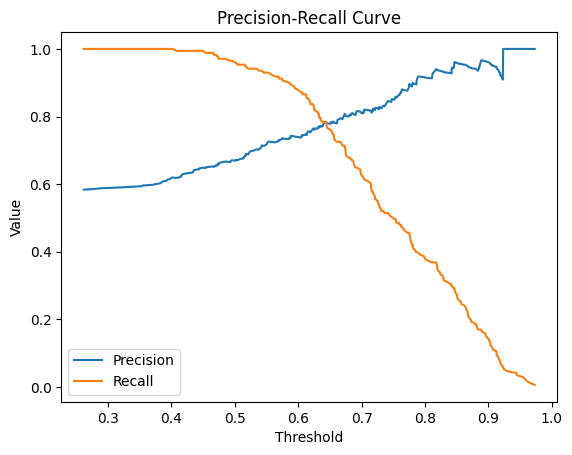

Threshold where precision and recall intersect: 0.644


In [6]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision and recall for thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred)

# Plot precision and recall curves
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

# Find the threshold where precision and recall intersect
intersection_idx = np.argmin(np.abs(precisions - recalls))
intersection_threshold = thresholds[intersection_idx]
print(f"Threshold where precision and recall intersect: {intersection_threshold:.3f}")

Question 4: F1 Score

In [12]:
# Compute F1 scores for thresholds
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])

# Find the threshold with the maximum F1 score
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]
print(f"Threshold with maximum F1 score: {best_f1_threshold:.3f}")

Threshold with maximum F1 score: 0.554


## Question 5: 5-Fold CV

In [8]:
from sklearn.model_selection import KFold

# Perform 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    y_train_fold = df_train_fold['converted']
    y_val_fold = df_val_fold['converted']
    
    X_train_fold = dv.fit_transform(df_train_fold[categorical + numerical].to_dict(orient='records'))
    X_val_fold = dv.transform(df_val_fold[categorical + numerical].to_dict(orient='records'))
    
    model.fit(X_train_fold, y_train_fold)
    y_val_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_val_pred_fold)
    auc_scores.append(auc)

# Calculate standard deviation of AUC scores
std_auc = np.std(auc_scores)
print(f"Standard deviation of AUC scores: {std_auc:.3f}")

Standard deviation of AUC scores: 0.036


## Question 6: Hyperparameter Tuning

In [9]:
# Hyperparameter tuning with 5-Fold CV
C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    auc_scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        y_train_fold = df_train_fold['converted']
        y_val_fold = df_val_fold['converted']
        
        X_train_fold = dv.fit_transform(df_train_fold[categorical + numerical].to_dict(orient='records'))
        X_val_fold = dv.transform(df_val_fold[categorical + numerical].to_dict(orient='records'))
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        y_val_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_val_pred_fold)
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results.append((C, mean_auc, std_auc))

# Find the best C
results = sorted(results, key=lambda x: (-x[1], x[2], x[0]))
best_C = results[0][0]
print(f"Best C: {best_C}")
print("Results:", results)

Best C: 0.001
Results: [(0.001, np.float64(0.8668780317675395), np.float64(0.028746230508215103)), (1, np.float64(0.8221089148573075), np.float64(0.03580711942905165)), (1e-06, np.float64(0.560207852870275), np.float64(0.023798316620649906))]
